In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing required libraries

In [ ]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import random
from skimage.util import view_as_blocks
from sklearn.feature_extraction import image

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

#Making path for train and test data

In [ ]:
train_path="/content/drive/MyDrive/Assignment2/50_images/bsds300/BSDS300/images/train"
test_path="/content/drive/MyDrive/Assignment2/50_images/bsds300/BSDS300/images/test"
train=load_images_from_folder(train_path)
test=load_images_from_folder(test_path)

#Making noise function for image

In [ ]:
def sp_noise(image,prob):                         
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255

            else:
                output[i][j] = image[i][j]
    return output

#Adding noise in temp and Making blur function(GaussinaBlur) for images

In [ ]:
print(len(train),len(test))

def noise(data):                    
    temp=[]
    for i in data:
        temp.append(sp_noise(i,0.004))
    return temp

  
def blur(data):                       
    fdata=[]
    for i in data:
        temp = cv2.GaussianBlur(i,(5, 5), cv2.BORDER_ISOLATED)
        fdata.append(temp)
    return fdata
bl_train=blur(train)
n_train=noise(bl_train)

50 50


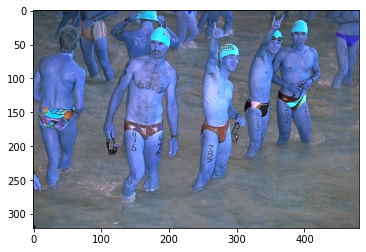

In [ ]:
plt.imshow(train[5])

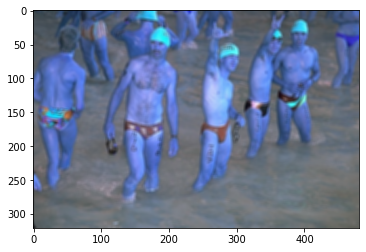

In [ ]:
plt.imshow(bl_train[5])

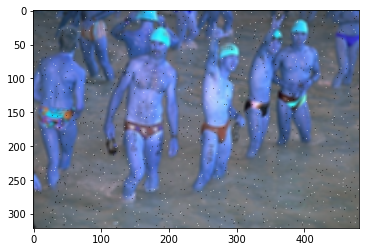

In [ ]:
plt.imshow(n_train[5])

#Extracting Patches of degradded images and Central pixel value of clean image

In [ ]:
import skimage              
#window size = 27 and per image number of patches is 50
#ML Model that I have tried are CNN and Random Forest.

x,y=[],[]
for i,j in zip(n_train,train):
    noisy_patches = image.extract_patches_2d(i, (27, 27),max_patches=50,random_state=1)
    clean_patches = image.extract_patches_2d(j, (27, 27),max_patches=50,random_state=1)
    for dd,cc in zip(noisy_patches,clean_patches):
        x.append(dd)
        central_pixel=cc[14,14]
        y.append(central_pixel)
print(len(x),len(y))


#         rv=random.randint(1, 1000000)
#         if(rv==5):        



        
    
#     for _ in range(1):
#         plt.imshow(noisy_patches[_*50])
#         plt.show()
#         plt.imshow(clean_patches[_*50])
#         plt.show()

2500 2500


#Splitting data training and testing

In [ ]:
train_x,train_y=x[:2000],y[:2000]
test_x,test_y=x[2000:],y[2000:]

print(len(train_x),len(test_x))

2000 500


#Normalizing data 

In [ ]:
train_x = np.array(train_x)
test_y = np.array(test_y)
train_y = np.array(train_y)
test_x = np.array(test_x)

train_x= train_x/255
train_y= train_y/255
test_y= test_y/255
train_y= train_y/255

train_r_y=train_y[:,0]
train_g_y=train_y[:,1]
train_b_y=train_y[:,2]

In [ ]:
train_x_RFR=np.reshape(train_x, (2000, -1))
train_x_RFR.shape

(2000, 2187)

In [ ]:
test_x_RFR=np.reshape(test_x, (500, -1))
train_y.shape

(2000, 3)

#Appliying Random Forest Regression (1st Method)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_x_RFR, train_y);

#Prediction on test data

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_x_RFR)

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
rmse_val = rmse(predictions, test_y)
print("rms error is: " + str(rmse_val))

rms error is: 0.5034693674609241


Above Geting RMSE of 0.502

#Making CNN Model (2nd Method)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 27, 27, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 23, 23, 128)  9728        Input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 11, 11, 128)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 256)    819456      max_pooling2d[0][0]              
______________________________________________________________________________________________

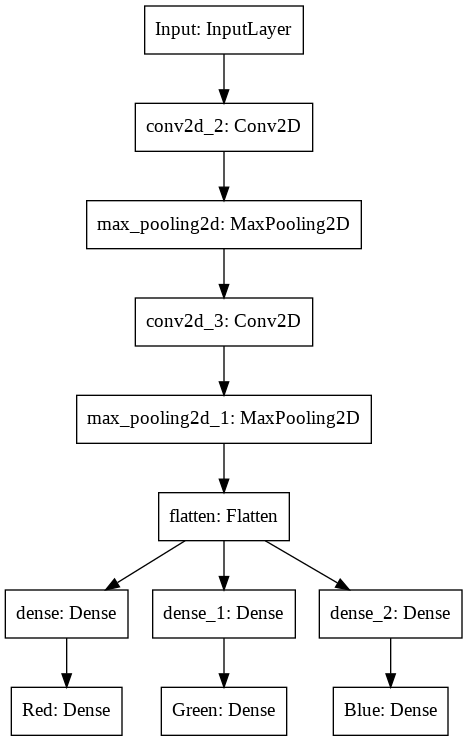

In [ ]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import layers
#Increasing Btch size and number of layer will give some better result
#After increasing window size more than 100. There are no advantage on result
#Yes I think making more complex network might have give better result

visible = Input(shape=(27,27,3), name="Input")
conv1 = layers.Conv2D(32, kernel_size=11, activation='relu')(visible)
# pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv2D(64, kernel_size=9, activation='relu')
# pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv1 = layers.Conv2D(128, kernel_size=5, activation='relu')(visible)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv2D(256, kernel_size=5, activation='relu')(pool1)
# conv2 = layers.Conv2D(1, kernel_size=1, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
flat = layers.Flatten()(pool2)
hidden1 = layers.Dense(128, activation='relu')(flat)
hidden2= layers.Dense(64, activation='relu')(flat)
hidden3= layers.Dense(64, activation='relu')(flat)

output1 = layers.Dense(1, activation='relu',name="Red")(hidden1)
output2 = layers.Dense(1, activation='relu',name="Green")(hidden2)
output3 = layers.Dense(1, activation='relu',name="Blue")(hidden3)

model = Model(inputs=visible, outputs=[output1,output2,output3])
# summarize layers
print(model.summary())
# plot graph
keras.utils.plot_model(model)
# model = tf.keras.()
# img_inputs = keras.Input(shape=(32, 32, 3))

#Adding loss function and the optimizer 

In [ ]:
import tensorflow as tf
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        tf.keras.losses.MeanAbsoluteError(),tf.keras.losses.MeanAbsoluteError()
        ,tf.keras.losses.MeanAbsoluteError()
    ],
    loss_weights=[1.0, 1.0, 1.0],
     metrics=["accuracy"]
)



#Fitting model 

In [ ]:
model.fit(
    {"Input":train_x},
    {"Red":train_r_y , "Green":train_g_y , "Blue":train_b_y},
    epochs=4,
    batch_size=32,
)



Epoch 1/4
63/63 [==============================] - 16s 228ms/step - loss: 0.0067 - Red_loss: 0.0016 - Green_loss: 0.0031 - Blue_loss: 0.0021 - Red_accuracy: 0.0055 - Green_accuracy: 0.0000e+00 - Blue_accuracy: 0.0040
Epoch 2/4
63/63 [==============================] - 14s 228ms/step - loss: 0.0052 - Red_loss: 0.0016 - Green_loss: 0.0018 - Blue_loss: 0.0018 - Red_accuracy: 0.0055 - Green_accuracy: 0.0000e+00 - Blue_accuracy: 0.0040
Epoch 3/4
63/63 [==============================] - 14s 228ms/step - loss: 0.0052 - Red_loss: 0.0016 - Green_loss: 0.0018 - Blue_loss: 0.0018 - Red_accuracy: 0.0055 - Green_accuracy: 0.0000e+00 - Blue_accuracy: 0.0040
Epoch 4/4
63/63 [==============================] - 14s 228ms/step - loss: 0.0052 - Red_loss: 0.0016 - Green_loss: 0.0018 - Blue_loss: 0.0018 - Red_accuracy: 0.0055 - Green_accuracy: 0.0000e+00 - Blue_accuracy: 0.0040


Getting loss value as 0.0052

#Predicting the model for test data

In [ ]:
y_pred=model.predict(test_x,batch_size=len(test_x),steps=1)


In [ ]:
rmse_val = rmse(y_pred, test_y)
print("rms error is: " + str(rmse_val))

rms error is: 0.5065938351911183
